In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
import matplotlib.pyplot as plt

In [19]:
bempp.api.GLOBAL_PARAMETERS.quadrature.regular = 1

In [24]:
length_ = 1 # length of each screen
width_ = 1  # width of each screen
dist_ = 0.25 # distance between the screens
h = 0.05 # grid size

corners1 = np.array([ [-0.5*width_, -0.5*length_, 0.5*dist_],
                     [-0.5*width_,  0.5*length_, 0.5*dist_],
                     [0.5*width_,   0.5*length_, 0.5*dist_],
                     [0.5*width_,  -0.5*length_, 0.5*dist_]])
corners2 = np.array([ [-0.5*width_, -0.5*length_, -0.5*dist_],
                     [-0.5*width_,  0.5*length_, -0.5*dist_],
                     [0.5*width_,   0.5*length_, -0.5*dist_],
                     [0.5*width_,  -0.5*length_, -0.5*dist_]])
grid1 = bempp.api.shapes.screen(corners1, h = h)
grid2 = bempp.api.shapes.screen(corners2, h = h)

space1 = bempp.api.function_space(grid1, "P", 1)
space2 = bempp.api.function_space(grid2, "P", 1)

In [25]:
N_wn = 15
lbound_wn = 0
ubound_wn = 30
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)
results = np.empty(N_wn, dtype='float64')

In [26]:
#wavenumber = 1j * (-np.log(quad_points[0]))
wavenumber = 0 * 1j

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space1, space1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space1, space1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space2, space2, wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space2, space2, wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                      [mat21_zero, mat22_inv]])  

combined_inverse_free = inv_free_mat2.dot(mat)
sign, logdet = slogdet(combined_inverse_free)

print(logdet)

-1.0244989346971554


In [28]:
mat12

array([[9.49070704e-07, 4.28260506e-07, 3.77385671e-07, ...,
        1.92586801e-07, 5.94107014e-07, 1.77742437e-07],
       [4.28260506e-07, 1.47275882e-06, 6.49067151e-07, ...,
        2.62630080e-07, 3.46569538e-07, 3.30680949e-07],
       [3.77385671e-07, 6.49067151e-07, 2.10509865e-06, ...,
        7.40049696e-07, 2.68411433e-07, 9.28410553e-07],
       ...,
       [1.92586801e-07, 2.62630080e-07, 7.40049696e-07, ...,
        5.35759481e-07, 1.31829832e-07, 2.95714765e-07],
       [5.94107014e-07, 3.46569538e-07, 2.68411433e-07, ...,
        1.31829832e-07, 4.68737290e-07, 1.27932206e-07],
       [1.77742437e-07, 3.30680949e-07, 9.28410553e-07, ...,
        2.95714765e-07, 1.27932206e-07, 4.50504667e-07]])

In [18]:
mat12

array([[4.78336772e-07, 3.63576637e-07, 3.43142421e-07, ...,
        1.74567324e-07, 3.25101853e-07, 1.60907783e-07],
       [3.63576637e-07, 7.44186162e-07, 5.49207300e-07, ...,
        2.34216080e-07, 2.81641063e-07, 2.71133892e-07],
       [3.43142421e-07, 5.49207300e-07, 1.06630958e-06, ...,
        4.75260899e-07, 2.43644750e-07, 4.85258865e-07],
       ...,
       [1.74567324e-07, 2.34216080e-07, 4.75260899e-07, ...,
        2.69509352e-07, 1.20107187e-07, 2.05500161e-07],
       [3.25101853e-07, 2.81641063e-07, 2.43644750e-07, ...,
        1.20107187e-07, 2.35702383e-07, 1.15345207e-07],
       [1.60907783e-07, 2.71133892e-07, 4.85258865e-07, ...,
        2.05500161e-07, 1.15345207e-07, 2.26512671e-07]])

ik = 0i
h = 0.05
4  -0.31670537174582625
6  -0.31670501857400957
8  -0.3167050124858009
10 -0.31670501148067065

ik = 0.8i
h = 0.05
4  -0.17746836634342386
6  -0.17746812644927373
8  -0.1774681224783512
10 -0.1774681218836629

ik = 20i
4  -5.906269362518298e-09
6  -5.90619908540084e-09
8  -5.906164557464773e-09
10 -5.906174438449691e-09

In [188]:
for index, point in enumerate(quad_points):

    wavenumber = -1j * np.log(point)

    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space1, space1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space1, space1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space2, space2, wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space2, space2, wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
    mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

    inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

    combined_inverse_free = inv_free_mat2.dot(mat)
    sign, logdet = slogdet(combined_inverse_free)
    
    results[index] = logdet
    print(f"Log Determinant: {index}: {logdet}")

Log Determinant: 0: 4.629630012686902e-13
Log Determinant: 1: -0.04414939776395672
Log Determinant: 2: -0.0764628930180869
Log Determinant: 3: -0.1046254984526845
Log Determinant: 4: -0.13020693566035788
Log Determinant: 5: -0.15393788032498343
Log Determinant: 6: -0.1762421645315886
Log Determinant: 7: -0.19739650241583712
Log Determinant: 8: -0.21759575223036548
Log Determinant: 9: -0.23698462739180012
Log Determinant: 10: -0.25567496742702517
Log Determinant: 11: -0.2737559454977187
Log Determinant: 12: -0.29130048596450014
Log Determinant: 13: -0.30836950005878666
Log Determinant: 14: -0.32501479364147284


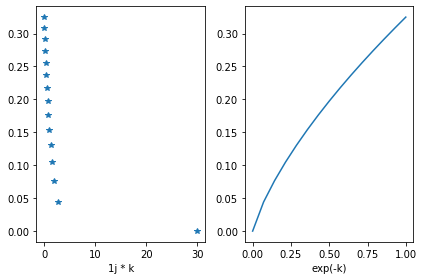

In [189]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = figure()
ax1 = fig.add_subplot(121)
ax1.set_xlabel('1j * k')
ax2 = fig.add_subplot(122)
ax2.set_xlabel('exp(-k)')
ax1.plot(-np.log(quad_points), -results, '*')
ax2.plot(quad_points, -results)
fig.tight_layout()

In [190]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)
print(f"The normalized Casimir Energy is: {casimir_energy}")

area_ = length_ * width_
casimir_energy_unit_area = casimir_energy/area_
print(f"The normalized Casimir Energy per unit area is: {casimir_energy_unit_area}")

The normalized Casimir Energy is: 0.03581990216858237
The normalized Casimir Energy per unit area is: 0.03581990216858237


The following paper states the Casimir energy between two perfectly conducting plates at a distance $a$ is:

$$\mathcal{E}_{\text{per unit area}}(a) = \frac{1}{2}\frac{\pi^{2}}{720}\frac{1}{a^{3}}$$

https://iopscience.iop.org/article/10.1088/1126-6708/2003/06/018/pdf?casa_token=lsiQlkbo0DQAAAAA:sDu0bRRkVhtihAFr3TrMvPw5yHmJeTAKXwWN59jyzKqZqh0PCE1-QuGkebrkYN13rHwq40nP

In [191]:
ref_ = 0.5 * (np.pi**2) /(720*(dist_**3))
print(casimir_energy_unit_area, ref_)

0.03581990216858237 0.05483113556160754


In [192]:
err_ = abs(casimir_energy_unit_area - ref_)/ref_
print(err_)

0.3467233205787686


    length * width    distance       grid size     exact                       Approx                        error

      1*1              1.5             0.1    0.002030782798578057      0.002814171205065016           0.38575686530114556
      3*3              1.5             0.1                              0.0025375789874001763          0.24955706202405062
      5*5              1.5             0.1                              0.0023586152885156143          0.16143158695607612
      7*7              1.5             0.1                              0.002271237346129418           0.11840485733862122
      10*10            1.5             0.1                              0.0022016075259544284          0.08411767496552654
      
      1*1              1.5             0.05                             0.0030144312624035443          0.4843691134838411
      3*3              1.5             0.05                             0.002594527382902751           0.27759964518087543
      5*5              1.5             0.05                             0.0023925234828681605          0.17812869231677178
      7*7              1.5             0.05                             0.0022945624595855432          0.12989063192389813          

      
      1*1              0.5             0.1    0.05483113556160754       0.07362666026678472            0.3427892658553236
      3*3              0.5             0.1                              0.07102641709570322            0.2953665170019846
      5*5              0.5             0.1                              0.07017040835847826            0.2797547896784979
      7*7              0.5             0.1                              0.06981345844640315            0.2732448039118516
      10*10            0.5             0.1                              0.06952916524473379            0.268059917646822
      
      1*1              0.5             0.05                             0.07846145209164035            0.43096529531988437
      3*3              0.5             0.05                             0.07262476226525072            0.3245168374025465
      
      

In [ ]:
Log Determinant: 0: -5.906278133280193e-09
Log Determinant: 1: -0.04283687908115191
Log Determinant: 2: -0.07423348819106923
Log Determinant: 3: -0.10162196420032935
Log Determinant: 4: -0.1265193992861447
Log Determinant: 5: -0.14963184542838487
Log Determinant: 6: -0.17136880172596944
Log Determinant: 7: -0.1919975952174648
Log Determinant: 8: -0.21170645138606625
Log Determinant: 9: -0.23063513736569127
Log Determinant: 10: -0.24889164987237247
Log Determinant: 11: -0.26656207731487164
Log Determinant: 12: -0.2837167996079831
Log Determinant: 13: -0.3004145796603663
Log Determinant: 14: -0.3167053717458566

In [104]:
-np.log(quad_points)

array([20.        ,  2.6390573 ,  1.94591014,  1.54044503,  1.25276296,
        1.02961941,  0.84729786,  0.69314718,  0.55961579,  0.44183275,
        0.33647224,  0.24116206,  0.15415068,  0.07410797, -0.        ])

In [ ]:
Log Determinant: 0: -7.593925488436077e-14
Log Determinant: 1: -0.042836878158210315
Log Determinant: 2: -0.07423348747347289
Log Determinant: 3: -0.10162196361114673
Log Determinant: 4: -0.12651939879315516
Log Determinant: 5: -0.14963184501329477
Log Determinant: 6: -0.17136880137733604
Log Determinant: 7: -0.19199759492680069
Log Determinant: 8: -0.21170645114754078
Log Determinant: 9: -0.23063513717410303
Log Determinant: 10: -0.24889164972440697
Log Determinant: 11: -0.26656207720723546
Log Determinant: 12: -0.28371679953827533
Log Determinant: 13: -0.30041457962639867
Log Determinant: 14: -0.3167053717458566

In [109]:
-np.log(quad_points)

array([40.        ,  2.63905733,  1.94591015,  1.54044504,  1.25276297,
        1.02961942,  0.84729786,  0.69314718,  0.55961579,  0.44183275,
        0.33647224,  0.24116206,  0.15415068,  0.07410797, -0.        ])

In [121]:
np.trapz(-np.array([-5.906278133280193e-09, -0.04283687908115191, -0.07423348819106923, -0.10162196420032935, -0.1265193992861447, 
         -0.14963184542838487, -0.17136880172596944, -0.1919975952174648, -0.21170645138606625,  -0.23063513736569127,
         -0.24889164987237247, -0.26656207731487164, -0.2837167996079831, -0.3004145796603663, -0.3167053717458566]), 
         x=[20.        ,  2.6390573 ,  1.94591014,  1.54044503,  1.25276296,
        1.02961941,  0.84729786,  0.69314718,  0.55961579,  0.44183275,
        0.33647224,  0.24116206,  0.15415068,  0.07410797, -0.        ])/(2*np.pi)

-0.1180897189424382

In [127]:
np.trapz([-7.593925488436077e-14, -0.04283687908115191, -0.07423348819106923, -0.10162196420032935, -0.1265193992861447, 
         -0.14963184542838487, -0.17136880172596944, -0.1919975952174648, -0.21170645138606625,  -0.23063513736569127,
         -0.24889164987237247, -0.26656207731487164, -0.2837167996079831, -0.3004145796603663, -0.3167053717458566], 
         [40.        ,  2.6390573 ,  1.94591014,  1.54044503,  1.25276296,
        1.02961941,  0.84729786,  0.69314718,  0.55961579,  0.44183275,
        0.33647224,  0.24116206,  0.15415068,  0.07410797, -0.        ])/(2*np.pi)

0.18626672130685623

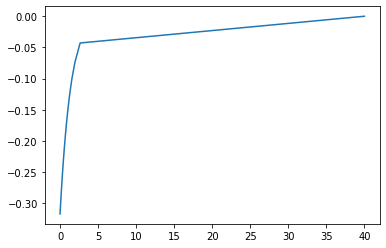

In [122]:
plt.plot([40.        ,  2.6390573 ,  1.94591014,  1.54044503,  1.25276296,
        1.02961941,  0.84729786,  0.69314718,  0.55961579,  0.44183275,
        0.33647224,  0.24116206,  0.15415068,  0.07410797, -0.        ], [-7.593925488436077e-14, -0.04283687908115191, -0.07423348819106923, -0.10162196420032935, -0.1265193992861447, 
         -0.14963184542838487, -0.17136880172596944, -0.1919975952174648, -0.21170645138606625,  -0.23063513736569127,
         -0.24889164987237247, -0.26656207731487164, -0.2837167996079831, -0.3004145796603663, -0.3167053717458566])

In [125]:
np.trapz([-1,-2,-3], [1,2,3])

-4.0

In [129]:
np.trapz([-7.593925488436077e-14, -0.04283687908115191], 
         [40.        ,  2.6390573 ])/(2*np.pi)

0.12735786918235795

In [131]:
results/quad_points

array([2.06115362e-09, 9.99999973e-01, 9.99999988e-01, 9.99999992e-01,
       9.99999995e-01, 9.99999996e-01, 9.99999997e-01, 9.99999998e-01,
       9.99999998e-01, 9.99999999e-01, 9.99999999e-01, 9.99999999e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [147]:
quad_points

array([4.24835426e-18, 7.14285714e-02, 1.42857143e-01, 2.14285714e-01,
       2.85714286e-01, 3.57142857e-01, 4.28571429e-01, 5.00000000e-01,
       5.71428571e-01, 6.42857143e-01, 7.14285714e-01, 7.85714286e-01,
       8.57142857e-01, 9.28571429e-01, 1.00000000e+00])

In [146]:
results

array([-7.59392549e-14, -4.28368782e-02, -7.42334875e-02, -1.01621964e-01,
       -1.26519399e-01, -1.49631845e-01, -1.71368801e-01, -1.91997595e-01,
       -2.11706451e-01, -2.30635137e-01, -2.48891650e-01, -2.66562077e-01,
       -2.83716800e-01, -3.00414580e-01, -3.16705372e-01])

In [149]:
result_20 = np.array([-5.90627813e-09, -4.28368791e-02, -7.42334882e-02, -1.01621964e-01,
       -1.26519399e-01, -1.49631845e-01, -1.71368802e-01, -1.91997595e-01,
       -2.11706451e-01, -2.30635137e-01, -2.48891650e-01, -2.66562077e-01,
       -2.83716800e-01, -3.00414580e-01, -3.16705372e-01])
quad_points_20 = np.array([2.06115362e-09, 7.14285733e-02, 1.42857145e-01, 2.14285716e-01,
       2.85714287e-01, 3.57142858e-01, 4.28571430e-01, 5.00000001e-01,
       5.71428572e-01, 6.42857144e-01, 7.14285715e-01, 7.85714286e-01,
       8.57142857e-01, 9.28571429e-01, 1.00000000e+00])

In [148]:
results_40 = np.array([-7.59392549e-14, -4.28368782e-02, -7.42334875e-02, -1.01621964e-01,
       -1.26519399e-01, -1.49631845e-01, -1.71368801e-01, -1.91997595e-01,
       -2.11706451e-01, -2.30635137e-01, -2.48891650e-01, -2.66562077e-01,
       -2.83716800e-01, -3.00414580e-01, -3.16705372e-01])
quad_points_40 = np.array([4.24835426e-18, 7.14285714e-02, 1.42857143e-01, 2.14285714e-01,
       2.85714286e-01, 3.57142857e-01, 4.28571429e-01, 5.00000000e-01,
       5.71428571e-01, 6.42857143e-01, 7.14285714e-01, 7.85714286e-01,
       8.57142857e-01, 9.28571429e-01, 1.00000000e+00])

In [150]:
result_20/quad_points_20

array([-2.86552059, -0.59971629, -0.51963441, -0.47423583, -0.44281789,
       -0.41896916, -0.39986054, -0.38399519, -0.37048629, -0.35876577,
       -0.34844831, -0.33926083, -0.33100293, -0.32352339, -0.31670537])

In [151]:
results_40/quad_points_40

array([-1.78749818e+04, -5.99716295e-01, -5.19634412e-01, -4.74235833e-01,
       -4.42817896e-01, -4.18969166e-01, -3.99860535e-01, -3.83995190e-01,
       -3.70486290e-01, -3.58765769e-01, -3.48448310e-01, -3.39260825e-01,
       -3.31002933e-01, -3.23523394e-01, -3.16705372e-01])